In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Depth Estimation

## Load sample image

C:\Users\isxzl\anaconda3\envs\engagement\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


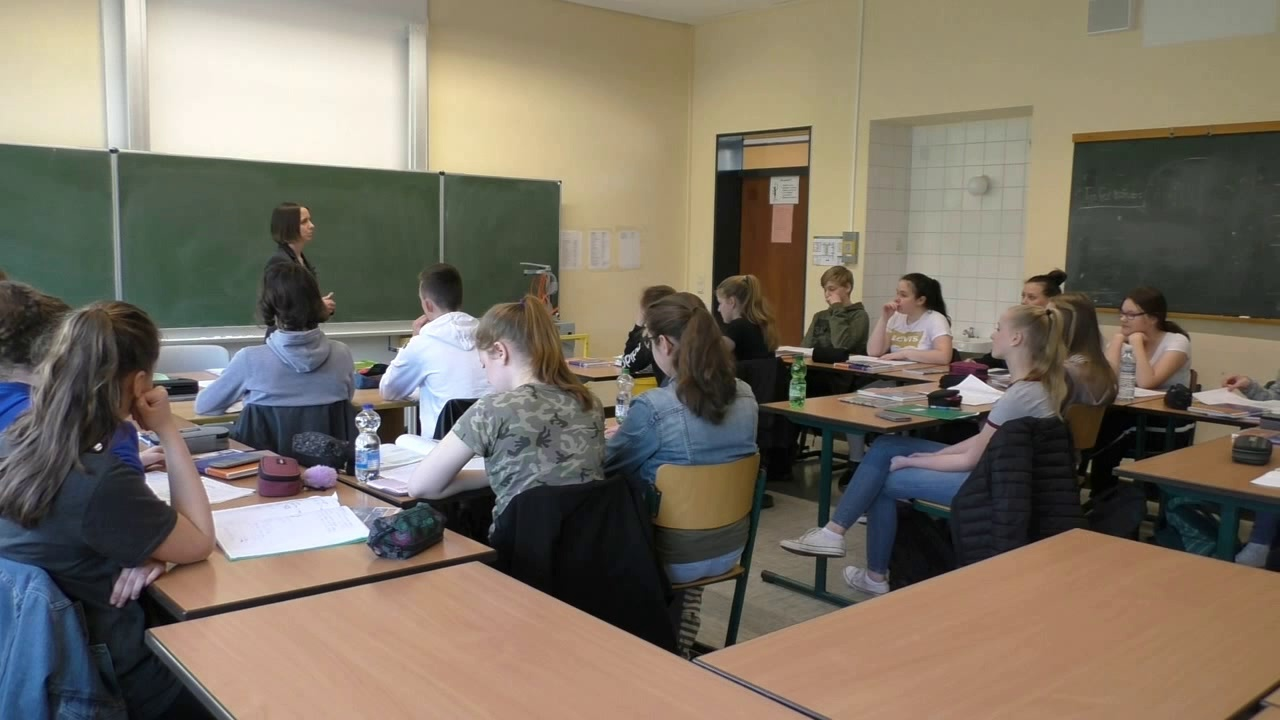

In [2]:
from transformers import AutoImageProcessor, DPTForDepthEstimation

image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-large-nyu")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-large-nyu")



from PIL import Image
import requests

url = r"C:\Datasets\Engagement\VIDEO000\00000\image_original\frame_0.jpg"
image = Image.open(url)
image

## Estimate depth on sample image Using DINO

In [3]:
import torch
import numpy as np
import matplotlib
from torchvision import transforms



def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])

# forward pass
transform = make_depth_transform()

 # input
img = Image.open(url)

# compute
rescaled_image = img.resize((img.width, img.height))
transformed_image = transform(rescaled_image)
inputs = image_processor(images=transformed_image, return_tensors="pt")

# Prediction
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = -outputs.predicted_depth.squeeze().cpu().numpy()


In [4]:

bits = 1

if not np.isfinite(predicted_depth).all():
    predicted_depth=np.nan_to_num(predicted_depth, nan=0.0, posinf=0.0, neginf=0.0)
    print("WARNING: Non-finite depth values present")

depth_min = predicted_depth.min()
depth_max = predicted_depth.max()

max_val = (2**(8*bits))-1

if depth_max - depth_min > np.finfo("float").eps:
    out = max_val * (predicted_depth - depth_min) / (depth_max - depth_min)
else:
    out = np.zeros(predicted_depth.shape, dtype=predicted_depth.dtype)
prediction_dino = cv2.applyColorMap(np.uint8(out), cv2.COLORMAP_INFERNO)

#cv2.imwrite(path + ".png", out.astype("uint16"))
Image.fromarray(prediction_dino)


NameError: name 'cv2' is not defined

## Using MIDAS

In [ ]:
import os
import sys
#TODO: add the path to MiDaS if not running the script from within the folder
#sys.path.append(r'..')
import glob
import torch
import utils
import cv2
from tqdm import tqdm
from torchvision.transforms import Compose
from midas.dpt_depth import DPTDepthModel
from midas.transforms import Resize, NormalizeImage, PrepareForNet
device='cuda'
model = DPTDepthModel(
    path="weights\\dpt_large-midas-2f21e586.pt",
    backbone="vitl16_384",
    non_negative=True,
)
net_w, net_h = 384, 384
resize_mode = "minimal"
normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method=resize_mode,
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

model.eval()
model = model.to(memory_format=torch.channels_last)  
model = model.half()
model.to(device)



# input
img = utils.read_image(url)
img_input = transform({"image": img})["image"]

# compute
with torch.no_grad():
    sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
    
    sample = sample.to(memory_format=torch.channels_last)
    sample = sample.half()
    prediction = model.forward(sample)
    depth = (
        torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        )
        .squeeze()
        .cpu()
        .numpy()
    )

In [ ]:
depth.min()

In [ ]:

bits = 1

if not np.isfinite(depth).all():
    depth=np.nan_to_num(depth, nan=0.0, posinf=0.0, neginf=0.0)
    print("WARNING: Non-finite depth values present")

depth_min = depth.min()
depth_max = depth.max()

max_val = (2**(8*bits))-1

if depth_max - depth_min > np.finfo("float").eps:
    out = max_val * (depth - depth_min) / (depth_max - depth_min)
else:
    out = np.zeros(depth.shape, dtype=depth.dtype)
prediction_midas = cv2.applyColorMap(np.uint8(out), cv2.COLORMAP_INFERNO)

#cv2.imwrite(path + ".png", out.astype("uint16"))
Image.fromarray(prediction_midas)
